# Isolation and Quantification of Colocalization in Nuclei

Loading image...
Loaded TIFF. Stack shape: (352, 352, 3)
Channel assignments:
 - Nuclei channel shape: (352, 352)
 - PCNA channel shape: (352, 352)
 - GFP channel shape: (352, 352)


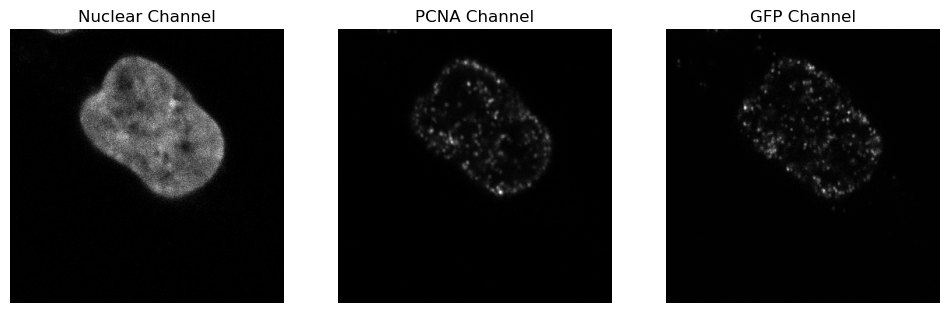

Segmenting nuclei...
Number of nuclei found: 1


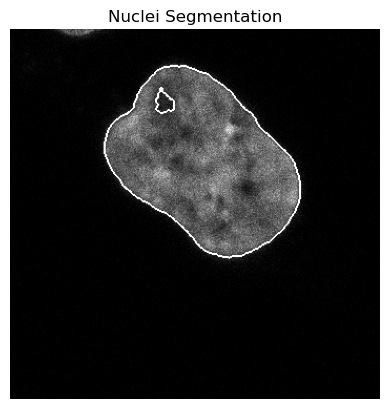

Computing colocalization metrics for each nucleus...
Nucleus 1: bbox=(35, 90, 218, 276), PCNA_pixels=21498, GFP_pixels=21498
  PearsonR=0.34159705572469995, M1=0.1979988807300767, M2=0.2236365115314083
Results saved.


In [3]:
import os
import numpy as np
import pandas as pd
from skimage import io, filters, measure, morphology, util
from skimage.filters import gaussian, threshold_otsu
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# -----------------------------------------------------------------------------
# Parameters
# -----------------------------------------------------------------------------
input_tif = 'Image_82.tif'
output_dir = 'coloc_results'
blur_sigma = 1.0
min_object_size = 200
hole_fill_size = 200

# Channel order:
# Channel 0 = DAPI
# Channel 1 = PCNA
# Channel 2 = GFP
nuclear_channel = 0
pcna_channel = 1
gfp_channel = 2
# -----------------------------------------------------------------------------

os.makedirs(output_dir, exist_ok=True)

print("Loading image...")
stack = io.imread(input_tif)
print(f"Loaded TIFF. Stack shape: {stack.shape}")

# Now stack is  (height, width, 3)
if stack.ndim != 3 or stack.shape[-1] < 3:
    raise ValueError("Expected an image of shape (H, W, 3) with three channels.")

# Extract each channel by indexing the last dimension
nuc_image = stack[:, :, nuclear_channel].astype(float)
pcna_image = stack[:, :, pcna_channel].astype(float)
gfp_image = stack[:, :, gfp_channel].astype(float)

print(f"Channel assignments:\n - Nuclei channel shape: {nuc_image.shape}\n - PCNA channel shape: {pcna_image.shape}\n - GFP channel shape: {gfp_image.shape}")

# Visualize channels
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(nuc_image, cmap='gray')
plt.title("Nuclear Channel")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(pcna_image, cmap='gray')
plt.title("PCNA Channel")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(gfp_image, cmap='gray')
plt.title("GFP Channel")
plt.axis('off')
plt.show()

# Segment nuclei using nuclear channel
print("Segmenting nuclei...")
nuc_blurred = gaussian(nuc_image, sigma=blur_sigma)
nuc_thresh_val = threshold_otsu(nuc_blurred)
nuc_binary = nuc_blurred > nuc_thresh_val

nuc_mask = morphology.remove_small_objects(nuc_binary, min_size=min_object_size)
nuc_mask = morphology.remove_small_holes(nuc_mask, area_threshold=hole_fill_size)

labeled_nuclei = measure.label(nuc_mask)
regions = measure.regionprops(labeled_nuclei)
print(f"Number of nuclei found: {len(regions)}")

if len(regions) == 0:
    print("Warning: No nuclei detected. Check segmentation parameters or input image.")

boundaries = find_boundaries(labeled_nuclei)
overlay = util.img_as_float(nuc_image)
overlay[boundaries] = overlay.max()

plt.figure()
plt.imshow(overlay, cmap='gray')
plt.title("Nuclei Segmentation")
plt.axis('off')
plt.show()

def compute_colocalization_metrics(ch1_pixels, ch2_pixels):
    if ch1_pixels.size == 0 or ch2_pixels.size == 0:
        print("Warning: Empty pixel array for colocalization.")
        return np.nan, np.nan, np.nan

    if np.all(ch1_pixels == 0) or np.all(ch2_pixels == 0):
        pearson_r = np.nan
    else:
        pearson_r, _ = pearsonr(ch1_pixels, ch2_pixels)
    
    # Manders Coefficients
    if np.any(ch1_pixels):
        ch1_thresh = threshold_otsu(ch1_pixels)
    else:
        ch1_thresh = 0
    
    if np.any(ch2_pixels):
        ch2_thresh = threshold_otsu(ch2_pixels)
    else:
        ch2_thresh = 0
    
    ch1_mask = ch1_pixels > ch1_thresh
    ch2_mask = ch2_pixels > ch2_thresh
    
    sum_ch1 = np.sum(ch1_pixels)
    sum_ch2 = np.sum(ch2_pixels)
    
    M1 = np.sum(ch1_pixels[ch2_mask]) / sum_ch1 if sum_ch1 > 0 else np.nan
    M2 = np.sum(ch2_pixels[ch1_mask]) / sum_ch2 if sum_ch2 > 0 else np.nan
    
    return pearson_r, M1, M2

print("Computing colocalization metrics for each nucleus...")
results = []
for i, region in enumerate(regions, start=1):
    minr, minc, maxr, maxc = region.bbox
    nucleus_mask = (labeled_nuclei[minr:maxr, minc:maxc] == region.label)
    
    pcna_pixels = pcna_image[minr:maxr, minc:maxc][nucleus_mask]
    gfp_pixels = gfp_image[minr:maxr, minc:maxc][nucleus_mask]
    
    print(f"Nucleus {i}: bbox={region.bbox}, PCNA_pixels={pcna_pixels.size}, GFP_pixels={gfp_pixels.size}")
    
    pearson_r, M1, M2 = compute_colocalization_metrics(pcna_pixels, gfp_pixels)
    print(f"  PearsonR={pearson_r}, M1={M1}, M2={M2}")
    
    results.append({
        'Nucleus_ID': i,
        'MinRow': minr,
        'MinCol': minc,
        'MaxRow': maxr,
        'MaxCol': maxc,
        'PearsonR': pearson_r,
        'MandersM1': M1,
        'MandersM2': M2
    })

if results:
    df = pd.DataFrame(results)
    df.to_csv(os.path.join(output_dir, 'colocalization_results.csv'), index=False)
    print("Results saved.")
else:
    print("No results to save. Possibly no nuclei detected or pixel extraction failed.")


In [ ]:
# Save pixel intensities for each nucleus

In [8]:
for i, region in enumerate(regions, start=1):
    minr, minc, maxr, maxc = region.bbox
    nucleus_mask = (labeled_nuclei[minr:maxr, minc:maxc] == region.label)
    
    pcna_pixels = pcna_image[minr:maxr, minc:maxc][nucleus_mask]
    gfp_pixels = gfp_image[minr:maxr, minc:maxc][nucleus_mask]
    
    print(f"Nucleus {i}:")
    print(f"  PCNA_pixels shape: {pcna_pixels.shape}, first 10: {pcna_pixels[:10]}")
    print(f"  GFP_pixels shape: {gfp_pixels.shape}, first 10: {gfp_pixels[:10]}")
    
    # Save pixel values to CSV files
    pcna_csv_path = os.path.join(output_dir, f'nucleus_{i}_pcna.csv')
    gfp_csv_path = os.path.join(output_dir, f'nucleus_{i}_gfp.csv')
    
    # Each CSV file will have one pixel value per line
    np.savetxt(pcna_csv_path, pcna_pixels, delimiter=',', fmt='%.6f', header='PCNA_pixel_values', comments='')
    np.savetxt(gfp_csv_path, gfp_pixels, delimiter=',', fmt='%.6f', header='GFP_pixel_values', comments='')
    
    # Compute colocalization metrics
    pearson_r, M1, M2 = compute_colocalization_metrics(pcna_pixels, gfp_pixels)
    print(f"  PearsonR={pearson_r}, M1={M1}, M2={M2}")


Nucleus 1:
  PCNA_pixels shape: (1577,), first 10: [ 193.   73.  117.  193. 1973.  108. 1182. 1723.  135.  738.]
  GFP_pixels shape: (1577,), first 10: [ 542.  453. 4425.  149.  316. 2317. 8940.  531.  488.  483.]
  PearsonR=-0.012116063942107524, M1=0.17398999686492592, M2=0.277612915514243
Nucleus 2:
  PCNA_pixels shape: (1434,), first 10: [ 651. 1882. 1696. 2317.  746. 1025.  150.  193.  895.  177.]
  GFP_pixels shape: (1434,), first 10: [1082.  355. 3700.  117. 2652. 1659. 2346. 1779.  154.  161.]
  PearsonR=0.02460603693062545, M1=0.1468281058617983, M2=0.3004140692046131
Nucleus 3:
  PCNA_pixels shape: (1037,), first 10: [1002.  230. 2132. 2501. 2540. 2090. 2057.  707.  916.    0.]
  GFP_pixels shape: (1037,), first 10: [ 893.  465.  271.  373.  268. 2532.  461. 1108.  301.  227.]
  PearsonR=0.26472842444378897, M1=0.1800200604259519, M2=0.22044253593280172
Nucleus 4:
  PCNA_pixels shape: (1176,), first 10: [1145. 3300.  387.  228.  141. 1351. 2022.  187. 1273. 2010.]
  GFP_pixel

In [4]:
print(nuc_thresh_val)

3892.593297813838
